## SUMMARY OF THIS NOTEBOOK

Attempt to combine LIME (explanation method) with Ensemble (uncertainty method). The LIME function needs a prediction function that returns some output. This output is then used to generate explanation for the input datapoint in question. Now, the ensemble prediction function used here produces two output, the mean of the ensemble mixture and the standard deviation of the ensemble mixture. An additional function (generate_sample_from_predicted_mean_and_std) is written that produces 1 sample from the mixture mean and mixture standard deviation. From this sample explanation is generated. 


<br> **STATUS (25_02_2022) : CODE WORKS FINE TILL THIS POINT** <br> 


Options to move forward: <br> 
Method 1: use the simple ensemble method and then for individual estimator, generate mean (simple ensemble anyway yield only mean). On this mean, generate explanation. Then combine the explanations generated by different estimators by computing the mean and standard deviation explanations  OR 

Method 2 : use the mixture_mean and mixture_std (as i have already done in this notebook). However, a small change to be taken into consideration is that rather than working with a single sample (from the mixture_mean and mixture_std) take multiple samples. Generate explanations for these samples and then figure out a way to combine these explanations from multiple samples. 


Essentially, the combined explanation should have the bar chart with varying length. As in, the length of the bar should have a corridor of uncertainty that itself is centered at the mean and then bounded by standard deviation. 

sort of what this piece of code does: <br>
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html <br>
https://matplotlib.org/3.1.1/gallery/statistics/errorbar_features.html

## Mount the drive

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing keras uncertainty

In [ ]:
# keras_uncertainty imports 
# clone and install this library 

!git clone https://github.com/mvaldenegro/keras-uncertainty.git
!pip install --user git+https://github.com/mvaldenegro/keras-uncertainty.git

%cd keras-uncertainty

fatal: destination path 'keras-uncertainty' already exists and is not an empty directory.
  Cloning https://github.com/mvaldenegro/keras-uncertainty.git to /tmp/pip-req-build-39w3funo
  Running command git clone -q https://github.com/mvaldenegro/keras-uncertainty.git /tmp/pip-req-build-39w3funo
/content/keras-uncertainty


## Installing LIME

In [ ]:
!pip install lime 
import lime 
import lime.lime_tabular 

!pip show lime

Name: lime
Version: 0.2.0.1
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, scikit-image, tqdm, numpy, matplotlib, scikit-learn
Required-by: 


##  Lime specific imports

In [ ]:
!pip install pyDOE2 

"""
Functions for explaining classifiers that use tabular data (matrices).
"""
import collections
import copy
from functools import partial
import json
import warnings
from collections import defaultdict

import numpy as np
import scipy as sp
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from pyDOE2 import lhs
from scipy.stats.distributions import norm
from pathlib import Path

from lime.discretize import QuartileDiscretizer
from lime.discretize import DecileDiscretizer
from lime.discretize import EntropyDiscretizer
from lime.discretize import BaseDiscretizer
from lime.discretize import StatsDiscretizer

## Lime classes 

## LIMEBASE 

In [ ]:
"""
Contains abstract functionality for learning locally linear sparse model.
"""
import numpy as np
import scipy as sp
from sklearn.linear_model import Ridge, lars_path, LinearRegression
from sklearn.utils import check_random_state


class LimeBase(object):
    """Class for learning a locally linear sparse model from perturbed data"""
    def __init__(self,
                 kernel_fn,
                 verbose=True,
                 random_state=None):
        """Init function
        Args:
            kernel_fn: function that transforms an array of distances into an
                        array of proximity values (floats).
            verbose: if true, print local prediction values from linear model.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.kernel_fn = kernel_fn
        self.verbose = verbose
        self.random_state = check_random_state(random_state)

    @staticmethod
    def generate_lars_path(weighted_data, weighted_labels):
        """Generates the lars path for weighted data.
        Args:
            weighted_data: data that has been weighted by kernel
            weighted_label: labels, weighted by kernel
        Returns:
            (alphas, coefs), both are arrays corresponding to the
            regularization parameter and coefficients, respectively
        """
        x_vector = weighted_data
        alphas, _, coefs = lars_path(x_vector,
                                     weighted_labels,
                                     method='lasso',
                                     verbose=False)
        return alphas, coefs

    def forward_selection(self, data, labels, weights, num_features):
        """Iteratively adds features to the model"""
        clf = Ridge(alpha=0, fit_intercept=True, random_state=self.random_state)
        used_features = []
        for _ in range(min(num_features, data.shape[1])):
            max_ = -100000000
            best = 0
            for feature in range(data.shape[1]):
                if feature in used_features:
                    continue
                clf.fit(data[:, used_features + [feature]], labels,
                        sample_weight=weights)
                score = clf.score(data[:, used_features + [feature]],
                                  labels,
                                  sample_weight=weights)
                if score > max_:
                    best = feature
                    max_ = score
            used_features.append(best)
        return np.array(used_features)

    def feature_selection(self, data, labels, weights, num_features, method):
        """Selects features for the model. see explain_instance_with_data to
           understand the parameters."""
        if method == 'none':
            return np.array(range(data.shape[1]))
        elif method == 'forward_selection':
            return self.forward_selection(data, labels, weights, num_features)
        elif method == 'highest_weights':
            clf = Ridge(alpha=0.01, fit_intercept=True,
                        random_state=self.random_state)
            clf.fit(data, labels, sample_weight=weights)

            coef = clf.coef_
            if sp.sparse.issparse(data):
                coef = sp.sparse.csr_matrix(clf.coef_)
                weighted_data = coef.multiply(data[0])
                # Note: most efficient to slice the data before reversing
                sdata = len(weighted_data.data)
                argsort_data = np.abs(weighted_data.data).argsort()
                # Edge case where data is more sparse than requested number of feature importances
                # In that case, we just pad with zero-valued features
                if sdata < num_features:
                    nnz_indexes = argsort_data[::-1]
                    indices = weighted_data.indices[nnz_indexes]
                    num_to_pad = num_features - sdata
                    indices = np.concatenate((indices, np.zeros(num_to_pad, dtype=indices.dtype)))
                    indices_set = set(indices)
                    pad_counter = 0
                    for i in range(data.shape[1]):
                        if i not in indices_set:
                            indices[pad_counter + sdata] = i
                            pad_counter += 1
                            if pad_counter >= num_to_pad:
                                break
                else:
                    nnz_indexes = argsort_data[sdata - num_features:sdata][::-1]
                    indices = weighted_data.indices[nnz_indexes]
                return indices
            else:
                weighted_data = coef * data[0]
                feature_weights = sorted(
                    zip(range(data.shape[1]), weighted_data),
                    key=lambda x: np.abs(x[1]),
                    reverse=True)
                return np.array([x[0] for x in feature_weights[:num_features]])
        elif method == 'lasso_path':
            weighted_data = ((data - np.average(data, axis=0, weights=weights))
                             * np.sqrt(weights[:, np.newaxis]))
            weighted_labels = ((labels - np.average(labels, weights=weights))
                               * np.sqrt(weights))
            nonzero = range(weighted_data.shape[1])
            _, coefs = self.generate_lars_path(weighted_data,
                                               weighted_labels)
            for i in range(len(coefs.T) - 1, 0, -1):
                nonzero = coefs.T[i].nonzero()[0]
                if len(nonzero) <= num_features:
                    break
            used_features = nonzero
            return used_features
        elif method == 'auto':
            if num_features <= 6:
                n_method = 'forward_selection'
            else:
                n_method = 'highest_weights'
            return self.feature_selection(data, labels, weights,
                                          num_features, n_method)

    def explain_instance_with_data(self,
                                   neighborhood_data,
                                   neighborhood_labels,
                                   distances,
                                   label,
                                   num_features,
                                   feature_selection='auto',
                                   model_regressor=None):
        """Takes perturbed data, labels and distances, returns explanation.
        Args:
            neighborhood_data: perturbed data, 2d array. first element is
                               assumed to be the original data point.
            neighborhood_labels: corresponding perturbed labels. should have as
                                 many columns as the number of possible labels.
            distances: distances to original data point.
            label: label for which we want an explanation
            num_features: maximum number of features in explanation
            feature_selection: how to select num_features. options are:
                'forward_selection': iteratively add features to the model.
                    This is costly when num_features is high
                'highest_weights': selects the features that have the highest
                    product of absolute weight * original data point when
                    learning with all the features
                'lasso_path': chooses features based on the lasso
                    regularization path
                'none': uses all features, ignores num_features
                'auto': uses forward_selection if num_features <= 6, and
                    'highest_weights' otherwise.
            model_regressor: sklearn regressor to use in explanation.
                Defaults to Ridge regression if None. Must have
                model_regressor.coef_ and 'sample_weight' as a parameter
                to model_regressor.fit()
        Returns:
            (intercept, exp, score, local_pred):
            intercept is a float.
            exp is a sorted list of tuples, where each tuple (x,y) corresponds
            to the feature id (x) and the local weight (y). The list is sorted
            by decreasing absolute value of y.
            score is the R^2 value of the returned explanation
            local_pred is the prediction of the explanation model on the original instance
        """

        weights = self.kernel_fn(distances)
        labels_column = neighborhood_labels[:, label]
        used_features = self.feature_selection(neighborhood_data,
                                               labels_column,
                                               weights,
                                               num_features,
                                               feature_selection)
        if model_regressor is None:
            model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)
            #model_regressor = LinearRegression(fit_intercept=True)
        easy_model = model_regressor
        easy_model.fit(neighborhood_data[:, used_features],
                       labels_column, sample_weight=weights)
        prediction_score = easy_model.score(
            neighborhood_data[:, used_features],
            labels_column, sample_weight=weights)

        local_pred = easy_model.predict(neighborhood_data[0, used_features].reshape(1, -1))

        if self.verbose:
            print('Neighborhood labels ', neighborhood_labels)
            print('Intercept', easy_model.intercept_)
            print('Prediction_local', local_pred,)
            print('Right:', neighborhood_labels[0, label])
            print('coefficients (these are the values that are printed as being the \'weights\' of the feature) ', easy_model.coef_)  # coefficients 
        return (easy_model.intercept_,
                sorted(zip(used_features, easy_model.coef_),
                       key=lambda x: np.abs(x[1]), reverse=True),
                prediction_score, local_pred)

## DOMAIN MAPPER & EXPLANATION 

In [ ]:
"""
Explanation class, with visualization functions.
"""
from io import open
import os
import os.path
import json
import string
import numpy as np

from sklearn.utils import check_random_state


class LimeError(Exception):
    """Raise for errors"""


def id_generator(size=15, random_state=None):
    """Helper function to generate random div ids. This is useful for embedding
    HTML into ipython notebooks."""
    chars = list(string.ascii_uppercase + string.digits)
    return ''.join(random_state.choice(chars, size, replace=True))


class DomainMapper(object):
    """Class for mapping features to the specific domain.
    The idea is that there would be a subclass for each domain (text, tables,
    images, etc), so that we can have a general Explanation class, and separate
    out the specifics of visualizing features in here.
    """

    def __init__(self):
        pass

    def map_exp_ids(self, exp, **kwargs):
        """Maps the feature ids to concrete names.
        Default behaviour is the identity function. Subclasses can implement
        this as they see fit.
        Args:
            exp: list of tuples [(id, weight), (id,weight)]
            kwargs: optional keyword arguments
        Returns:
            exp: list of tuples [(name, weight), (name, weight)...]
        """
        return exp

    def visualize_instance_html(self,
                                exp,
                                label,
                                div_name,
                                exp_object_name,
                                **kwargs):
        """Produces html for visualizing the instance.
        Default behaviour does nothing. Subclasses can implement this as they
        see fit.
        Args:
             exp: list of tuples [(id, weight), (id,weight)]
             label: label id (integer)
             div_name: name of div object to be used for rendering(in js)
             exp_object_name: name of js explanation object
             kwargs: optional keyword arguments
        Returns:
             js code for visualizing the instance
        """
        return ''


class Explanation(object):
    """Object returned by explainers."""

    def __init__(self,
                 domain_mapper,
                 mode='classification',
                 class_names=None,
                 random_state=None,
                 explanation_id=None):
        """
        Initializer.
        Args:
            domain_mapper: must inherit from DomainMapper class
            type: "classification" or "regression"
            class_names: list of class names (only used for classification)
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.random_state = random_state
        self.mode = mode
        self.domain_mapper = domain_mapper
        self.local_exp = defaultdict(list)#
        self.intercept = defaultdict(list)#
        self.score = defaultdict(list)#
        self.local_pred = defaultdict(list)#
        self.explanation_id= explanation_id
        if mode == 'classification':
            self.class_names = class_names
            self.top_labels = None
            self.predict_proba = None
        elif mode == 'regression':
            self.class_names = ['negative', 'positive']
            self.predicted_value = None
            self.min_value = 0.0
            self.max_value = 1.0
            self.dummy_label = 1
        else:
            raise LimeError('Invalid explanation mode "{}". '
                            'Should be either "classification" '
                            'or "regression".'.format(mode))

    def available_labels(self):
        """
        Returns the list of classification labels for which we have any explanations.
        """
        try:
            assert self.mode == "classification"
        except AssertionError:
            raise NotImplementedError('Not supported for regression explanations.')
        else:
            ans = self.top_labels if self.top_labels else self.local_exp.keys()
            return list(ans)

    def as_list(self, label=1, **kwargs):
        """Returns the explanation as a list.
        Args:
            label: desired label. If you ask for a label for which an
                explanation wasn't computed, will throw an exception.
                Will be ignored for regression explanations.
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            list of tuples (representation, weight), where representation is
            given by domain_mapper. Weight is a float.
        """
        label_to_use = label if self.mode == "classification" else self.dummy_label
        ans = self.domain_mapper.map_exp_ids(self.local_exp[label_to_use], **kwargs)
        ans = [(x[0], float(x[1])) for x in ans]
        return ans

    def as_map(self):
        """Returns the map of explanations.
        Returns:
            Map from label to list of tuples (feature_id, weight).
        """
        return self.local_exp

    def as_pyplot_figure(self, label=1, figsize=(4,4), **kwargs):
        """Returns the explanation as a pyplot figure.
        Will throw an error if you don't have matplotlib installed
        Args:
            label: desired label. If you ask for a label for which an
                   explanation wasn't computed, will throw an exception.
                   Will be ignored for regression explanations.
            figsize: desired size of pyplot in tuple format, defaults to (4,4).
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            pyplot figure (barchart).
        """
        import matplotlib.pyplot as plt
        exp = self.as_list(label=label, **kwargs)
        fig = plt.figure(figsize=figsize)
        vals = [x[1] for x in exp]
        names = [x[0] for x in exp]
        vals.reverse()
        names.reverse()
        colors = ['C1' if x > 0 else 'C0' for x in vals] # originally negative=red and positive=green (coloring scheme)
        colors_set = set(colors)
        print('colors_set before ', colors_set)
        colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
        print('colors_set after ', colors_set)
        pos = np.arange(len(exp)) + .5
        print('pos values for plot are ', pos)
        print('vals ', vals)
        print('names ', names)
        vals_str = [str(round(val, 3)) for val in vals]
        print('vals_str ', vals_str)
        
        plt.figure(figsize=(15, 10))
        #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

        #colors = ['r', 'g', 'b']
        labels = colors_set 
        legend_colors = list(set(colors))
        print(legend_colors)
        handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        print(handles)
       
        vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
        print('vals ', vals)

        for i, v in enumerate(vals):
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =.8)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
        axx = plt.barh([i for i in pos], vals, align='center', color=colors) # this code appropriate legend
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

        plt.yticks(pos, names)
        if self.mode == "classification":
            title = 'Local explanation for class %s' % self.class_names[label]
        else:
            title = 'Local explanation'
        plt.title(title+' for test input '+str(self.explanation_id))
        #plt.legend()
        plt.xlabel('feature coefficient')
        plt.grid()
        plt.tight_layout()

        return fig

    def show_in_notebook(self,
                         labels=None,
                         predict_proba=True,
                         show_predicted_value=True,
                         **kwargs):
        """Shows html explanation in ipython notebook.
        See as_html() for parameters.
        This will throw an error if you don't have IPython installed"""

        from IPython.core.display import display, HTML
        display(HTML(self.as_html(labels=labels,
                                  predict_proba=predict_proba,
                                  show_predicted_value=show_predicted_value,
                                  **kwargs)))

    def save_to_file(self,
                     file_path,
                     labels=None,
                     predict_proba=True,
                     show_predicted_value=True,
                     **kwargs):
        """Saves html explanation to file. .
        Params:
            file_path: file to save explanations to
        See as_html() for additional parameters.
        """
        file_ = open(file_path, 'w', encoding='utf8')
        file_.write(self.as_html(labels=labels,
                                 predict_proba=predict_proba,
                                 show_predicted_value=show_predicted_value,
                                 **kwargs))
        file_.close()

    def as_html(self,
                labels=None,
                predict_proba=True,
                show_predicted_value=True,
                **kwargs):
        """Returns the explanation as an html page.
        Args:
            labels: desired labels to show explanations for (as barcharts).
                If you ask for a label for which an explanation wasn't
                computed, will throw an exception. If None, will show
                explanations for all available labels. (only used for classification)
            predict_proba: if true, add  barchart with prediction probabilities
                for the top classes. (only used for classification)
            show_predicted_value: if true, add  barchart with expected value
                (only used for regression)
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            code for an html page, including javascript includes.
        """

        def jsonize(x):
            return json.dumps(x, ensure_ascii=False)

        if labels is None and self.mode == "classification":
            labels = self.available_labels()


        #this_dir, _ = os.path.split(__file__) # this code gave error that __file__ not defined 
        this_dir = '/usr/local/lib/python3.7/dist-packages/lime/' # intentional hardcoding of the path 
        
        bundle = open(os.path.join(this_dir, 'bundle.js'),
                      encoding="utf8").read()

        out = u'''<html>
        <meta http-equiv="content-type" content="text/html; charset=UTF8">
        <head><script>%s </script></head><body>''' % bundle
        random_id = id_generator(size=15, random_state=check_random_state(self.random_state))
        out += u'''
        <div class="lime top_div" id="top_div%s"></div>
        ''' % random_id

        predict_proba_js = ''
        if self.mode == "classification" and predict_proba:
            predict_proba_js = u'''
            var pp_div = top_div.append('div')
                                .classed('lime predict_proba', true);
            var pp_svg = pp_div.append('svg').style('width', '100%%');
            var pp = new lime.PredictProba(pp_svg, %s, %s);
            ''' % (jsonize([str(x) for x in self.class_names]),
                   jsonize(list(self.predict_proba.astype(float))))

        predict_value_js = ''
        if self.mode == "regression" and show_predicted_value:
            # reference self.predicted_value
            # (svg, predicted_value, min_value, max_value)
            predict_value_js = u'''
                    var pp_div = top_div.append('div')
                                        .classed('lime predicted_value', true);
                    var pp_svg = pp_div.append('svg').style('width', '100%%');
                    var pp = new lime.PredictedValue(pp_svg, %s, %s, %s);
                    ''' % (jsonize(float(self.predicted_value)),
                           jsonize(float(self.min_value)),
                           jsonize(float(self.max_value)))

        exp_js = '''var exp_div;
            var exp = new lime.Explanation(%s);
        ''' % (jsonize([str(x) for x in self.class_names]))

        if self.mode == "classification":
            for label in labels:
                exp = jsonize(self.as_list(label))
                exp_js += u'''
                exp_div = top_div.append('div').classed('lime explanation', true);
                exp.show(%s, %d, exp_div);
                ''' % (exp, label)
        else:
            exp = jsonize(self.as_list())
            exp_js += u'''
            exp_div = top_div.append('div').classed('lime explanation', true);
            exp.show(%s, %s, exp_div);
            ''' % (exp, self.dummy_label)

        raw_js = '''var raw_div = top_div.append('div');'''

        if self.mode == "classification":
            html_data = self.local_exp[labels[0]]
        else:
            html_data = self.local_exp[self.dummy_label]

        raw_js += self.domain_mapper.visualize_instance_html(
                html_data,
                labels[0] if self.mode == "classification" else self.dummy_label,
                'raw_div',
                'exp',
                **kwargs)
        out += u'''
        <script>
        var top_div = d3.select('#top_div%s').classed('lime top_div', true);
        %s
        %s
        %s
        %s
        </script>
        ''' % (random_id, predict_proba_js, predict_value_js, exp_js, raw_js)
        out += u'</body></html>'

        return out

## BASEDISCRETIZER & ITS DERIVATIVE CLASS

In [ ]:
"""
Discretizers classes, to be used in lime_tabular
"""
import numpy as np
import sklearn
import sklearn.tree
import scipy
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod


class BaseDiscretizer():
    """
    Abstract class - Build a class that inherits from this class to implement
    a custom discretizer.
    Method bins() is to be redefined in the child class, as it is the actual
    custom part of the discretizer.
    """

    __metaclass__ = ABCMeta  # abstract class

    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None,
                 data_stats=None):
        """Initializer
        Args:
            data: numpy 2d array
            categorical_features: list of indices (ints) corresponding to the
                categorical columns. These features will not be discretized.
                Everything else will be considered continuous, and will be
                discretized.
            categorical_names: map from int to list of names, where
                categorical_names[x][y] represents the name of the yth value of
                column x.
            feature_names: list of names (strings) corresponding to the columns
                in the training data.
            data_stats: must have 'means', 'stds', 'mins' and 'maxs', use this
                if you don't want these values to be computed from data
        """
        print('Inside BaseDiscretizer __init__')
        self.to_discretize = ([x for x in range(data.shape[1])
                               if x not in categorical_features])
        print('to_discretize :', self.to_discretize)
        self.data_stats = data_stats
        self.names = defaultdict(list)#    solution taken from https://stackoverflow.com/questions/23297569/python-key-error-0-cant-find-dict-error-in-code 
        self.lambdas = defaultdict(list)#
        self.means = defaultdict(list)#
        self.stds = defaultdict(list)#
        self.mins = defaultdict(list)#
        self.maxs = defaultdict(list)#
        self.random_state = check_random_state(random_state)

        # To override when implementing a custom binning
        bins = self.bins(data, labels)
        bins = [np.unique(x) for x in bins]
        print('bins :', bins)

        # Read the stats from data_stats if exists
        if data_stats:
            self.means = self.data_stats.get("means")
            self.stds = self.data_stats.get("stds")
            self.mins = self.data_stats.get("mins")
            self.maxs = self.data_stats.get("maxs")

        for feature, qts in zip(self.to_discretize, bins):
            n_bins = qts.shape[0]  # Actually number of borders (= #bins-1)
            print(f'n_bins for feature ({feature}) \'{feature_names[feature]}\' and qts {qts} is {n_bins}')
            boundaries = np.min(data[:, feature]), np.max(data[:, feature])
            print(f'boundaries : {boundaries}')
            name = feature_names[feature]
            print(f'feature_names {name}')

            self.names[feature] = ['%s <= %.2f' % (name, qts[0])]
            for i in range(n_bins - 1):
                self.names[feature].append('%.2f < %s <= %.2f' %
                                           (qts[i], name, qts[i + 1]))
                print('statements to be added')
                print('%.2f < %s <= %.2f' %(qts[i], name, qts[i + 1]))

            self.names[feature].append('%s > %.2f' % (name, qts[n_bins - 1]))
            print('statements to be added')
            print('%s > %.2f' % (name, qts[n_bins - 1]))

            self.lambdas[feature] = lambda x, qts=qts: np.searchsorted(qts, x)    # this is how searchsorted works : np.searchsorted([1,2,3,4,5], 3) : answer-> 2 (shape of output is same as second argument)
            print(f'lambdas : {self.lambdas[feature]}')
            print(f'data[:, features] {data[:, feature]}')
            print(f'qts : {qts}')
            discretized = self.lambdas[feature](data[:, feature])  # all np.searsorted does is attempt to identify those indices where the data[:,features] values could be inserted within the qts array 
            print('discretized :', discretized)
            print('len of discretized :', len(discretized))
            # If data stats are provided no need to compute the below set of details
            if data_stats:
                continue

            self.means[feature] = []
            self.stds[feature] = []
            for x in range(n_bins + 1):
                selection = data[discretized == x, feature]
                mean = 0 if len(selection) == 0 else np.mean(selection)
                self.means[feature].append(mean)
                std = 0 if len(selection) == 0 else np.std(selection)
                std += 0.00000000001
                self.stds[feature].append(std)
            self.mins[feature] = [boundaries[0]] + qts.tolist()
            self.maxs[feature] = qts.tolist() + [boundaries[1]]


            print(f'mins self.mins[feature] {self.mins[feature]}')
            print(f'maxs self.maxs[feature] {self.maxs[feature]}')

    @abstractmethod
    def bins(self, data, labels):
        """
        To be overridden
        Returns for each feature to discretize the boundaries
        that form each bin of the discretizer
        """
        raise NotImplementedError("Must override bins() method")

    def discretize(self, data):
        """Discretizes the data.
        Args:
            data: numpy 2d or 1d array
        Returns:
            numpy array of same dimension, discretized.
        """
        ret = data.copy()
        for feature in self.lambdas:
            if len(data.shape) == 1:
                ret[feature] = int(self.lambdas[feature](ret[feature]))
            else:
                ret[:, feature] = self.lambdas[feature](
                    ret[:, feature]).astype(int)
        return ret

    def get_undiscretize_values(self, feature, values):
        mins = np.array(self.mins[feature])[values]
        maxs = np.array(self.maxs[feature])[values]

        means = np.array(self.means[feature])[values]
        stds = np.array(self.stds[feature])[values]
        minz = (mins - means) / stds
        maxz = (maxs - means) / stds
        min_max_unequal = (minz != maxz)

        ret = minz
        ret[np.where(min_max_unequal)] = scipy.stats.truncnorm.rvs(
            minz[min_max_unequal],
            maxz[min_max_unequal],
            loc=means[min_max_unequal],
            scale=stds[min_max_unequal],
            random_state=self.random_state
        )
        return ret

    def undiscretize(self, data):
        ret = data.copy()
        for feature in self.means:
            if len(data.shape) == 1:
                ret[feature] = self.get_undiscretize_values(
                    feature, ret[feature].astype(int).reshape(-1, 1)
                )
            else:
                ret[:, feature] = self.get_undiscretize_values(
                    feature, ret[:, feature].astype(int)
                )
        return ret


class StatsDiscretizer(BaseDiscretizer):
    """
        Class to be used to supply the data stats info when discretize_continuous is true
    """

    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None,
                 data_stats=None):

        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state,
                                 data_stats=data_stats)

    def bins(self, data, labels):
        bins_from_stats = self.data_stats.get("bins")
        bins = []
        if bins_from_stats is not None:
            for feature in self.to_discretize:
                bins_from_stats_feature = bins_from_stats.get(feature)
                if bins_from_stats_feature is not None:
                    qts = np.array(bins_from_stats_feature)
                    bins.append(qts)
        return bins


class QuartileDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):

        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            qts = np.array(np.percentile(data[:, feature], [25, 50, 75]))
            bins.append(qts)
        return bins


class DecileDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):
        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            qts = np.array(np.percentile(data[:, feature],
                                         [10, 20, 30, 40, 50, 60, 70, 80, 90]))
            bins.append(qts)
        return bins


class EntropyDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):
        if(labels is None):
            raise ValueError('Labels must be not None when using \
                             EntropyDiscretizer')
        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            # Entropy splitting / at most 8 bins so max_depth=3
            dt = sklearn.tree.DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=3,
                                                     random_state=self.random_state)
            x = np.reshape(data[:, feature], (-1, 1))
            dt.fit(x, labels)
            qts = dt.tree_.threshold[np.where(dt.tree_.children_left > -1)]

            if qts.shape[0] == 0:
                qts = np.array([np.median(data[:, feature])])
            else:
                qts = np.sort(qts)

            bins.append(qts)

        return bins

## TABLEDOMAINMAPPER & LIMETABULAREXPLAINER

In [ ]:
class TableDomainMapper(DomainMapper):
    """Maps feature ids to names, generates table views, etc"""

    def __init__(self, feature_names, feature_values, scaled_row,
                 categorical_features, discretized_feature_names=None,
                 feature_indexes=None):
        """Init.
        Args:
            feature_names: list of feature names, in order
            feature_values: list of strings with the values of the original row
            scaled_row: scaled row
            categorical_features: list of categorical features ids (ints)
            feature_indexes: optional feature indexes used in the sparse case
        """
        self.exp_feature_names = feature_names
        self.discretized_feature_names = discretized_feature_names
        self.feature_names = feature_names
        self.feature_values = feature_values
        self.feature_indexes = feature_indexes
        self.scaled_row = scaled_row
        if sp.sparse.issparse(scaled_row):
            self.all_categorical = False
        else:
            self.all_categorical = len(categorical_features) == len(scaled_row)
        self.categorical_features = categorical_features

    def map_exp_ids(self, exp):
        """Maps ids to feature names.
        Args:
            exp: list of tuples [(id, weight), (id,weight)]
        Returns:
            list of tuples (feature_name, weight)
        """
        names = self.exp_feature_names
        if self.discretized_feature_names is not None:
            names = self.discretized_feature_names
        return [(names[x[0]], x[1]) for x in exp]

    def visualize_instance_html(self,
                                exp,
                                label,
                                div_name,
                                exp_object_name,
                                show_table=True,
                                show_all=False):
        """Shows the current example in a table format.
        Args:
             exp: list of tuples [(id, weight), (id,weight)]
             label: label id (integer)
             div_name: name of div object to be used for rendering(in js)
             exp_object_name: name of js explanation object
             show_table: if False, don't show table visualization.
             show_all: if True, show zero-weighted features in the table.
        """
        if not show_table:
            return ''
        weights = [0] * len(self.feature_names)
        for x in exp:
            weights[x[0]] = x[1]
            print_weights = [round(t, 3) for t in weights]
            print('weights ', print_weights)
        if self.feature_indexes is not None:
            # Sparse case: only display the non-zero values and importances
            fnames = [self.exp_feature_names[i] for i in self.feature_indexes]
            print('fnames ', fnames)
            fweights = [weights[i] for i in self.feature_indexes]
            print('fweights ', fweights)
            if show_all:
                out_list = list(zip(fnames,
                                    self.feature_values,
                                    fweights))
            else:
                out_dict = dict(map(lambda x: (x[0], (x[1], x[2], x[3])),
                                zip(self.feature_indexes,
                                    fnames,
                                    self.feature_values,
                                    fweights)))
                out_list = [out_dict.get(x[0], (str(x[0]), 0.0, 0.0)) for x in exp]
        else:
            out_list = list(zip(self.exp_feature_names,
                                self.feature_values,
                                weights))
            if not show_all:
                out_list = [out_list[x[0]] for x in exp]
        ret = u'''
            %s.show_raw_tabular(%s, %d, %s);
        ''' % (exp_object_name, json.dumps(out_list, ensure_ascii=False), label, div_name)
        return ret


class LimeTabularExplainer(object):
    """Explains predictions on tabular (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self,
                 training_data,
                 mode="classification",
                 training_labels=None,
                 feature_names=None,
                 categorical_features=None,
                 categorical_names=None,
                 kernel_width=None,
                 kernel=None,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 discretize_continuous=True,
                 discretizer='quartile',
                 sample_around_instance=False,
                 random_state=None,
                 training_data_stats=None):
        """Init function.
        Args:
            training_data: numpy 2d array
            mode: "classification" or "regression"
            training_labels: labels for training data. Not required, but may be
                used by discretizer.
            feature_names: list of names (strings) corresponding to the columns
                in the training data.
            categorical_features: list of indices (ints) corresponding to the
                categorical columns. Everything else will be considered
                continuous. Values in these columns MUST be integers.
            categorical_names: map from int to list of names, where
                categorical_names[x][y] represents the name of the yth value of
                column x.
            kernel_width: kernel width for the exponential kernel.
                If None, defaults to sqrt (number of columns) * 0.75
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            class_names: list of class names, ordered according to whatever the
                classifier is using. If not present, class names will be '0',
                '1', ...
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            discretize_continuous: if True, all non-categorical features will
                be discretized into quartiles.
            discretizer: only matters if discretize_continuous is True
                and data is not sparse. Options are 'quartile', 'decile',
                'entropy' or a BaseDiscretizer instance.
            sample_around_instance: if True, will sample continuous features
                in perturbed samples from a normal centered at the instance
                being explained. Otherwise, the normal is centered on the mean
                of the feature data.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
            training_data_stats: a dict object having the details of training data
                statistics. If None, training data information will be used, only matters
                if discretize_continuous is True. Must have the following keys:
                means", "mins", "maxs", "stds", "feature_values",
                "feature_frequencies"
        """

        print('Inside __init__ of LimeTabularExplainer')

        self.random_state = check_random_state(random_state)
        self.mode = mode
        self.categorical_names = categorical_names or defaultdict(list)#
        self.sample_around_instance = sample_around_instance
        self.training_data_stats = training_data_stats
    
        
        print('mode :', self.mode)
        print('sample_around_instance :', self.sample_around_instance)
        print('training_data_stats :', self.training_data_stats) 

        # Check and raise proper error in stats are supplied in non-descritized path
        if self.training_data_stats:
            self.validate_training_data_stats(self.training_data_stats)

        if categorical_features is None:
            categorical_features = []
        if feature_names is None:
            feature_names = [str(i) for i in range(training_data.shape[1])]

        self.categorical_features = list(categorical_features)
        self.feature_names = list(feature_names)

        print('categorical_features :', categorical_features)
        print('feature_names :', feature_names)
        
        self.discretizer = None
        if discretize_continuous and not sp.sparse.issparse(training_data):
            # Set the discretizer if training data stats are provided
            if self.training_data_stats:
                discretizer = StatsDiscretizer(
                    training_data, self.categorical_features,
                    self.feature_names, labels=training_labels,
                    data_stats=self.training_data_stats,
                    random_state=self.random_state)

            if discretizer == 'quartile':
                self.discretizer = QuartileDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif discretizer == 'decile':
                self.discretizer = DecileDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif discretizer == 'entropy':
                self.discretizer = EntropyDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif isinstance(discretizer, BaseDiscretizer):
                self.discretizer = discretizer
            else:
                raise ValueError('''Discretizer must be 'quartile',''' +
                                 ''' 'decile', 'entropy' or a''' +
                                 ''' BaseDiscretizer instance''')
            self.categorical_features = list(range(training_data.shape[1]))

            print('discretizer object returned :', self.discretizer) 
            print('discretizer in use :', discretizer)
            
            # Get the discretized_training_data when the stats are not provided
            if(self.training_data_stats is None):
                print('training_data_stats are not provided')
                discretized_training_data = self.discretizer.discretize(
                    training_data)

        if kernel_width is None:
            kernel_width = np.sqrt(training_data.shape[1]) * .75
        kernel_width = float(kernel_width)

        print('kernel_width to be used : ', kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.feature_selection = feature_selection
        self.base = LimeBase(kernel_fn, verbose, random_state=self.random_state)
        print('LimeBase object :', self.base)
        self.class_names = class_names

        print('class_names :', class_names)

        # Though set has no role to play if training data stats are provided
        self.scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
        self.scaler.fit(training_data)
        self.feature_values = defaultdict(list)#
        self.feature_frequencies = defaultdict(list)#

        for feature in self.categorical_features:
            if training_data_stats is None:
                if self.discretizer is not None:
                    column = discretized_training_data[:, feature]
                else:
                    column = training_data[:, feature]

                feature_count = collections.Counter(column)
                values, frequencies = map(list, zip(*(sorted(feature_count.items()))))
            else:
                values = training_data_stats["feature_values"][feature]
                frequencies = training_data_stats["feature_frequencies"][feature]

            self.feature_values[feature] = values
            self.feature_frequencies[feature] = (np.array(frequencies) /
                                                 float(sum(frequencies)))
            self.scaler.mean_[feature] = 0
            self.scaler.scale_[feature] = 1

    @staticmethod
    def convert_and_round(values):
        return ['%.4f' % v for v in values]

    @staticmethod
    def validate_training_data_stats(training_data_stats):
        """
            Method to validate the structure of training data stats
        """
        stat_keys = list(training_data_stats.keys())
        valid_stat_keys = ["means", "mins", "maxs", "stds", "feature_values", "feature_frequencies"]
        missing_keys = list(set(valid_stat_keys) - set(stat_keys))
        if len(missing_keys) > 0:
            raise Exception("Missing keys in training_data_stats. Details: %s" % (missing_keys))

    def explain_instance(self,
                         data_row,
                         predict_fn,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=5000,
                         distance_metric='euclidean',
                         model_regressor=None,
                         sampling_method='gaussian',
                         id=None):
        """Generates explanations for a prediction.
        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).
        Args:
            data_row: 1d numpy array or scipy.sparse matrix, corresponding to a row
            predict_fn: prediction function. For classifiers, this should be a
                function that takes a numpy array and outputs prediction
                probabilities. For regressors, this takes a numpy array and
                returns the predictions. For ScikitClassifiers, this is
                `classifier.predict_proba()`. For ScikitRegressors, this
                is `regressor.predict()`. The prediction function needs to work
                on multiple feature vectors (the vectors randomly perturbed
                from the data_row).
            labels: iterable with labels to be explained.
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            distance_metric: the distance metric to use for weights.
            model_regressor: sklearn regressor to use in explanation. Defaults
                to Ridge regression in LimeBase. Must have model_regressor.coef_
                and 'sample_weight' as a parameter to model_regressor.fit()
            sampling_method: Method to sample synthetic data. Defaults to Gaussian
                sampling. Can also use Latin Hypercube Sampling.
        Returns:
            An Explanation object (see explanation.py) with the corresponding
            explanations.
        """
        print('Inside the explain_instance function')
        if sp.sparse.issparse(data_row) and not sp.sparse.isspmatrix_csr(data_row):
            # Preventative code: if sparse, convert to csr format if not in csr format already
            data_row = data_row.tocsr()

        print('data_row \n', data_row)
        data, inverse = self.__data_inverse(data_row, num_samples, sampling_method)
        print('data \n', data)
        print('data shape \n', data.shape)
        print('inverse \n', inverse)
        print('inverse shape \n', inverse.shape)
        if sp.sparse.issparse(data):
            # Note in sparse case we don't subtract mean since data would become dense
            scaled_data = data.multiply(self.scaler.scale_)
            # Multiplying with csr matrix can return a coo sparse matrix
            if not sp.sparse.isspmatrix_csr(scaled_data):
                scaled_data = scaled_data.tocsr()
        else:
            scaled_data = (data - self.scaler.mean_) / self.scaler.scale_
        
        print('scaled data \n', scaled_data)
        print('scaled data \n', scaled_data.shape)
        distances = sklearn.metrics.pairwise_distances(
                scaled_data,
                scaled_data[0].reshape(1, -1),
                metric=distance_metric
        ).ravel()
        print('distances \n', distances)
        print('len distances \n', len(distances))
        yss = predict_fn(inverse)
        print('yss \n ', yss)
        print('yss shape \n', yss.shape)

        # for classification, the model needs to provide a list of tuples - classes
        # along with prediction probabilities
        if self.mode == "classification":
            if len(yss.shape) == 1:
                raise NotImplementedError("LIME does not currently support "
                                          "classifier models without probability "
                                          "scores. If this conflicts with your "
                                          "use case, please let us know: "
                                          "https://github.com/datascienceinc/lime/issues/16")
            elif len(yss.shape) == 2:
                if self.class_names is None:
                    self.class_names = [str(x) for x in range(yss[0].shape[0])]
                else:
                    self.class_names = list(self.class_names)
                if not np.allclose(yss.sum(axis=1), 1.0):
                    warnings.warn("""
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    """)
            else:
                raise ValueError("Your model outputs "
                                 "arrays with {} dimensions".format(len(yss.shape)))

        # for regression, the output should be a one-dimensional array of predictions
        else:
            try:
                if len(yss.shape) != 1 and len(yss[0].shape) == 1:
                    yss = np.array([v[0] for v in yss])
                assert isinstance(yss, np.ndarray) and len(yss.shape) == 1
            except AssertionError:
                raise ValueError("Your model needs to output single-dimensional \
                    numpyarrays, not arrays of {} dimensions".format(yss.shape))

            predicted_value = yss[0]
            print('predicted value \n', predicted_value)
            min_y = min(yss)
            print('min_y value \n', min_y)
            max_y = max(yss)
            print('max_y value \n', max_y)

            # add a dimension to be compatible with downstream machinery
            yss = yss[:, np.newaxis]
            print('yss new shape \n', yss.shape)

        feature_names = copy.deepcopy(self.feature_names)
        print('feature_names ', feature_names)
        if feature_names is None:
            print('feature_names is None')
            feature_names = [str(x) for x in range(data_row.shape[0])]
            print('feature_names after assignment ', feature_names)

        if sp.sparse.issparse(data_row):
            values = self.convert_and_round(data_row.data)
            feature_indexes = data_row.indices
        else:
            values = self.convert_and_round(data_row)
            feature_indexes = None

        for i in self.categorical_features:
            if self.discretizer is not None and i in self.discretizer.lambdas:
                continue
            name = int(data_row[i])
            print('name ', name)
            if i in self.categorical_names:
                name = self.categorical_names[i][name]
            feature_names[i] = '%s=%s' % (feature_names[i], name)
            values[i] = 'True'
        categorical_features = self.categorical_features

        discretized_feature_names = None
        print('discretized feature names \n', discretized_feature_names)

        if self.discretizer is not None:
            print('discretizer is NOT none')
            categorical_features = range(data.shape[1])
            print('data_row before discretization ', data_row)
            print('data_row type ', type(data_row))
            print('data_row shape before discretization ', data_row.shape)
            discretized_instance = self.discretizer.discretize(data_row)
            print('discretized_instance after discretzation \n', discretized_instance)  
            discretized_feature_names = copy.deepcopy(feature_names)
            print('discretized_feature_names \n', discretized_feature_names)
            for f in self.discretizer.names:
                discretized_feature_names[f] = self.discretizer.names[f][int(
                        discretized_instance[f])]

        print('discretized_feature_names \n', discretized_feature_names)
        domain_mapper = TableDomainMapper(feature_names,
                                          values,
                                          scaled_data[0],
                                          categorical_features=categorical_features,
                                          discretized_feature_names=discretized_feature_names,
                                          feature_indexes=feature_indexes)
        print('domain_mapper object ', domain_mapper)
        print('domain_mapper feature names \n ', domain_mapper.feature_names)
        print('scaled_data[0] ', scaled_data[0])
        print('discretized_feature_names \n ',domain_mapper.discretized_feature_names)
        ret_exp = Explanation(domain_mapper,
                                          mode=self.mode,
                                          class_names=self.class_names,
                                          explanation_id=id)
        print('ret_exp object', ret_exp)
        print('local_exp object ', ret_exp.local_exp)
        print('ret_exp intercept \n ', ret_exp.intercept)

        if self.mode == "classification":
            ret_exp.predict_proba = yss[0]
            if top_labels:
                labels = np.argsort(yss[0])[-top_labels:]
                ret_exp.top_labels = list(labels)
                ret_exp.top_labels.reverse()
        else:
            print('regression')
            ret_exp.predicted_value = predicted_value
            ret_exp.min_value = min_y
            ret_exp.max_value = max_y
            print('ret_exp type', type(ret_exp))
            print('ret_exp predicted_value ', ret_exp.predicted_value)
            print('ret_exp min_value ', ret_exp.min_value)
            print('ret_exp max_value ', ret_exp.max_value)
            labels = [0]

        for label in labels:
            print('labels ', label)
            print('scaled data is ', scaled_data)
            print('scaled data shape ', scaled_data.shape)
            print('yss is ', yss)
            print('yss shape ', yss.shape)
            print('distances ', distances)
            print('distances shape ', distances.shape)
            print()
            print('num features ', num_features)
            print('model regressor ', model_regressor)
            print('feature selection ', self.feature_selection)
            print()
            print(f'Printing the values for LABEL {label}')
            print('ret exp predicted value ', ret_exp.predicted_value)
            print('ret exp min value ', ret_exp.min_value)
            print('ret exp max value ', ret_exp.max_value)
            print('ret exp intercept ', ret_exp.intercept)
            print('ret exp intercept label ', ret_exp.intercept[label])
            print('ret exp local exp ', ret_exp.local_exp)
            print('ret exp local exp label ', ret_exp.local_exp[label])
            print('ret exp score ', ret_exp.score)
            print('ret exp score label ', ret_exp.score[label])
            print('ret exp local pred ', ret_exp.local_pred)
            print('type of ret exp local pred ', type(ret_exp.local_pred))
            print('ret exp loxal pred label ', ret_exp.local_pred[label])
            print()
            print(f'assignment for label {label}')
            (ret_exp.intercept[label],
            ret_exp.local_exp[label],
            ret_exp.score[label],
            ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                    scaled_data,
                    yss,
                    distances,
                    label,
                    num_features,
                    model_regressor=model_regressor,
                    feature_selection=self.feature_selection)
    
        if self.mode == "regression":
            ret_exp.intercept[1] = ret_exp.intercept[0]
            ret_exp.local_exp[1] = [x for x in ret_exp.local_exp[0]]
            ret_exp.local_exp[0] = [(i, -1 * j) for i, j in ret_exp.local_exp[1]]

            print('ret_exp.intercept[1] ', ret_exp.intercept[0])
            print('ret_exp.local_exp[1] ', ret_exp.local_exp[1])
            print('ret_exp.local_exp[0] ', ret_exp.local_exp[0])

        return ret_exp

    def __data_inverse(self,
                       data_row,
                       num_samples,
                       sampling_method):
        """Generates a neighborhood around a prediction.
        For numerical features, perturb them by sampling from a Normal(0,1) and
        doing the inverse operation of mean-centering and scaling, according to
        the means and stds in the training data. For categorical features,
        perturb by sampling according to the training distribution, and making
        a binary feature that is 1 when the value is the same as the instance
        being explained.
        Args:
            data_row: 1d numpy array, corresponding to a row
            num_samples: size of the neighborhood to learn the linear model
            sampling_method: 'gaussian' or 'lhs'
        Returns:
            A tuple (data, inverse), where:
                data: dense num_samples * K matrix, where categorical features
                are encoded with either 0 (not equal to the corresponding value
                in data_row) or 1. The first row is the original instance.
                inverse: same as data, except the categorical features are not
                binary, but categorical (as the original data)
        """
        is_sparse = sp.sparse.issparse(data_row)
        if is_sparse:
            num_cols = data_row.shape[1]
            data = sp.sparse.csr_matrix((num_samples, num_cols), dtype=data_row.dtype)
        else:
            num_cols = data_row.shape[0]
            data = np.zeros((num_samples, num_cols))
        categorical_features = range(num_cols)
        if self.discretizer is None:
            instance_sample = data_row
            scale = self.scaler.scale_
            mean = self.scaler.mean_
            if is_sparse:
                # Perturb only the non-zero values
                non_zero_indexes = data_row.nonzero()[1]
                num_cols = len(non_zero_indexes)
                instance_sample = data_row[:, non_zero_indexes]
                scale = scale[non_zero_indexes]
                mean = mean[non_zero_indexes]

            if sampling_method == 'gaussian':
                data = self.random_state.normal(0, 1, num_samples * num_cols
                                                ).reshape(num_samples, num_cols)
                data = np.array(data)
            elif sampling_method == 'lhs':
                data = lhs(num_cols, samples=num_samples
                           ).reshape(num_samples, num_cols)
                means = np.zeros(num_cols)
                stdvs = np.array([1]*num_cols)
                for i in range(num_cols):
                    data[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(data[:, i])
                data = np.array(data)
            else:
                warnings.warn('''Invalid input for sampling_method.
                                 Defaulting to Gaussian sampling.''', UserWarning)
                data = self.random_state.normal(0, 1, num_samples * num_cols
                                                ).reshape(num_samples, num_cols)
                data = np.array(data)

            if self.sample_around_instance:
                data = data * scale + instance_sample
            else:
                data = data * scale + mean
            if is_sparse:
                if num_cols == 0:
                    data = sp.sparse.csr_matrix((num_samples,
                                                 data_row.shape[1]),
                                                dtype=data_row.dtype)
                else:
                    indexes = np.tile(non_zero_indexes, num_samples)
                    indptr = np.array(
                        range(0, len(non_zero_indexes) * (num_samples + 1),
                              len(non_zero_indexes)))
                    data_1d_shape = data.shape[0] * data.shape[1]
                    data_1d = data.reshape(data_1d_shape)
                    data = sp.sparse.csr_matrix(
                        (data_1d, indexes, indptr),
                        shape=(num_samples, data_row.shape[1]))
            categorical_features = self.categorical_features
            first_row = data_row
        else:
            first_row = self.discretizer.discretize(data_row)
        data[0] = data_row.copy()
        inverse = data.copy()
        for column in categorical_features:
            values = self.feature_values[column]
            freqs = self.feature_frequencies[column]
            inverse_column = self.random_state.choice(values, size=num_samples,
                                                      replace=True, p=freqs)
            binary_column = (inverse_column == first_row[column]).astype(int)
            binary_column[0] = 1
            inverse_column[0] = data[0, column]
            data[:, column] = binary_column
            inverse[:, column] = inverse_column
        if self.discretizer is not None:
            inverse[1:] = self.discretizer.undiscretize(inverse[1:])
        inverse[0] = data_row
        return data, inverse

## Setting flags for running explanation

In [ ]:
ensemble = True 
dropout = False 
dropconnect = False 
flipout = False 

## Keras uncertainty specific imports 

In [ ]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import load_model
import random
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

import keras_uncertainty
from keras_uncertainty.models import StochasticRegressor, TwoHeadStochasticRegressor
from keras_uncertainty.models.DeepEnsembleClassifier import DeepEnsemble

from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, StochasticDropout
from keras_uncertainty.metrics import gaussian_interval_score
from keras_uncertainty.losses import regression_gaussian_nll_loss, regression_gaussian_beta_nll_loss
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True) 

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# if eager execution is not disabled following error occurs:
# TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), 
#dtype=tf.float32, name=None), name='Placeholder:0', description="created 
#by layer 'tf.cast_4'"), an intermediate Keras symbolic input/output, 
#to a TF API that does not allow registering custom dispatchers, 
#such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. 
#Keras Functional model construction only supports TF API calls that 
#*do* support dispatching, such as `tf.math.add` or `tf.reshape`. 
#Other APIs cannot be called directly on symbolic Kerasinputs/outputs. 
#You can work around this limitation by putting the operation in a custom 
#Keras layer `call` and calling that layer on this symbolic input/output.

Keras Uncertainty will use standalone Keras backend

## Load Dataset

In [ ]:
# load the california housing data from csv
train_file = '/content/sample_data/california_housing_train.csv'
test_file = '/content/sample_data/california_housing_test.csv'

train_combined = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# split the data in validation and test (from test.csv)
train, val = train_test_split(train_combined, test_size=0.25)

feature_names = list(train_combined.columns)
print(feature_names)

# assign the target variable
target = 'median_house_value'

# extract the target label in all sets
train_labels_df= train[target]
val_labels_df = val[target]
test_labels_df = test[target]

# extract the data from all sets 
train_data_df = train.drop(columns=target, axis=1)
val_data_df = val.drop(columns=target, axis=1)
test_data_df = test.drop(columns=target, axis=1)

train_data_unnormalized = train_data_df.to_numpy()
train_labels_unnormalized = train_labels_df.to_numpy()

val_data_unnormalized = val_data_df.to_numpy()
val_labels_unnormalized = val_labels_df.to_numpy()

test_data_unnormalized = test_data_df.to_numpy()
test_labels_unnormalized = test_labels_df.to_numpy()

# normalize the data using minmax 
minmax = MinMaxScaler() 

train_data = minmax.fit_transform(train_data_unnormalized)
train_label_temp = np.expand_dims(train_labels_unnormalized, axis=1)
train_labels = minmax.fit_transform(train_label_temp)

val_data = minmax.fit_transform(val_data_unnormalized)
val_label_temp = np.expand_dims(val_labels_unnormalized, axis=1)
val_labels = minmax.fit_transform(val_label_temp)

test_data = minmax.fit_transform(test_data_unnormalized)
test_label_temp = np.expand_dims(test_labels_unnormalized, axis=1)
test_labels = minmax.fit_transform(test_label_temp)


print('Training data shape \n', train_data.shape)
print('Training labels shape \n', train_labels.shape)
#print('Training data \n ', train_data)
#print('Training labels \n ', train_labels)

print('Validation data shape \n ',val_data.shape)
print('Validation labels shape \n ', val_labels.shape)
#print('Validation data \n ', val_data)
#print('Validation labels \n ', val_labels)

print('Test data shape \n ', test_data.shape)
print('Test labels shape \n ', test_labels.shape)
#print('Test data \n ', test_data)
#print('Test labels \n ', test_labels)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## DeepEnsembleRegressor

In [ ]:
class DeepEnsembleRegressor(DeepEnsemble):
    """
        Implementation of a Deep Ensemble for regression.
        Uses two models, one for training and another for inference/testing. The user has to provide a model function that returns
        the train and test models, and use the provided deep_ensemble_nll_loss for training.
    """
    def __init__(self, model_fn=None, num_estimators=None, models=None):
        """
            Builds a Deep Ensemble given a function to make model instances, and the number of estimators.
            For training it uses a model that only outputs the mean, while the loss uses both the mean and variance produced by the model.
            For testing, a model that shares weights with the training model is used, but the testing model outputs both mean and variance. The final
            prediction is made with a mixture of gaussians, where each gaussian is one trained model instance.
        """
        super().__init__(model_fn=model_fn, num_estimators=num_estimators, models=models,
                         needs_test_estimators=True)

    def fit(self, X, y, epochs=10, batch_size=32, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            history = self.train_estimators[i].fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs)


            #if not os.path.exists(path+'/results/ensemble'):
            #    os.makedirs(path+'/results/ensemble')

            # plotting history for individual ensemble component 
            plt.plot(range(epochs), history.history['loss'], label='training loss')
            plt.plot(range(epochs), history.history['val_loss'], label='val loss')
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('Ensemble component '+str(i)+' loss plot')
            plt.legend()
            #plt.savefig(path+'results/ensemble/loss_plot_'+str(i)+'.pdf')
            plt.show()

            plt.plot(range(epochs), history.history['mae'], label='training mae')
            plt.plot(range(epochs), history.history['val_mae'], label='val mae')
            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel('mae')
            plt.title('Ensemble component '+str(i)+' mae plot') 
            #plt.savefig(path+'results/ensemble/mae_plot_'+str(i)+'.pdf')
            plt.show()
            
            # saving the individual ensemble component 
            #self.train_estimators[i].save(path+'results/ensemble/model_'+str(i)+'.h5')
    
    def fit_generator(self, generator, epochs=10, **kwargs):
        """
            Fits the Deep Ensemble, each estimator is fit independently on the same data.
        """

        for i in range(self.num_estimators):
            self.train_estimators[i].fit_generator(generator, epochs=epochs, **kwargs)
            

    def predict_mean(self, X, batch_size=32, output_scaler=None, num_ensembles=None, disentangle_uncertainty=False, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

    
        for estimator in estimators:
            mean, var  = estimator.predict(X, batch_size=batch_size, **kwargs)

            if output_scaler is not None:
                mean = output_scaler.inverse_transform(mean)

                # This should work but not sure if its 100% correct
                # Its not clear how to do inverse scaling of the variance
                sqrt_var = np.sqrt(var)
                var = output_scaler.inverse_transform(sqrt_var)
                var = np.square(var)

            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        if disentangle_uncertainty:
            epi_var = np.var(means, axis=0)
            ale_var = np.mean(variances, axis=0)

            return mixture_mean, np.sqrt(ale_var), np.sqrt(epi_var)

        #return mixture_mean, np.sqrt(mixture_var)
        return mixture_mean


    # INTENTIONALLY REPLICATING THE CODE BODY HOWEVER NOTICE THAT THE RETURN STATEMENTS ARE DIFFERENT FOR ALL THESE PREDICT FUNCTIONS (split the predict function into 3 parts: 
    # predict_mean, predict_std and generate_....... so that these functions could be passed into the lime code to generate explanations)
    def predict_std(self, X, batch_size=32, output_scaler=None, num_ensembles=None, disentangle_uncertainty=False, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for estimator in estimators:
            mean, var  = estimator.predict(X, batch_size=batch_size, **kwargs)

            if output_scaler is not None:
                mean = output_scaler.inverse_transform(mean)

                # This should work but not sure if its 100% correct
                # Its not clear how to do inverse scaling of the variance
                sqrt_var = np.sqrt(var)
                var = output_scaler.inverse_transform(sqrt_var)
                var = np.square(var)

            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        if disentangle_uncertainty:
            epi_var = np.var(means, axis=0)
            ale_var = np.mean(variances, axis=0)

            return mixture_mean, np.sqrt(ale_var), np.sqrt(epi_var)

        #return mixture_mean, np.sqrt(mixture_var)
        return np.sqrt(mixture_var)


    # INTENTIONALLY REPLICATING THE CODE BODY HOWEVER NOTICE THAT THE RETURN STATEMENTS ARE DIFFERENT FOR ALL THESE PREDICT FUNCTIONS 
    def generate_sample_from_predicted_mean_and_std(self, X, batch_size=32, output_scaler=None, num_ensembles=None, disentangle_uncertainty=False, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for estimator in estimators:
            mean, var  = estimator.predict(X, batch_size=batch_size, **kwargs)

            if output_scaler is not None:
                mean = output_scaler.inverse_transform(mean)

                # This should work but not sure if its 100% correct
                # Its not clear how to do inverse scaling of the variance
                sqrt_var = np.sqrt(var)
                var = output_scaler.inverse_transform(sqrt_var)
                var = np.square(var)
            
            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        if disentangle_uncertainty:
            epi_var = np.var(means, axis=0)
            ale_var = np.mean(variances, axis=0)

            return mixture_mean, np.sqrt(ale_var), np.sqrt(epi_var)

        #return mixture_mean, np.sqrt(mixture_var)
        print('mean \n', mean)
        print('std \n', mixture_var)

        sample = np.random.normal(mixture_mean, np.sqrt(mixture_var))
        print('sample : \n', sample)
        print('mean sample : \n', np.mean(sample))
        print('sample shape : \n', sample.shape)
        return sample

    def predict_generator(self, generator, steps=None, num_ensembles=None, **kwargs):
        """
            Makes a prediction. Predictions from each estimator are used to build a gaussian mixture and its mean and standard deviation returned.
        """
        
        means = []
        variances = []

        if num_ensembles is None:
            estimators = self.test_estimators
        else:
            estimators = self.test_estimators[:num_ensembles]

        for estimator in estimators:
            mean, var  = estimator.predict_generator(generator, steps=steps, **kwargs)
            means.append(mean)
            variances.append(var)

        means = np.array(means)
        variances = np.array(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(variances + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
                
        return mixture_mean, np.sqrt(mixture_var)

## Ensemble Explanation

In [ ]:
# ENSEMBLE MODEL
def train_ensemble_model(x_train, y_train, x_val, y_val, x_test, epochs, num_estimators):
    def model():
        # this model definition has been obtained from the hyperparameter optimization 
        # not the last layer though
        inp = Input(shape=(8,))
        x = Dense(4, activation='tanh')(inp)
        x = Dense(4, activation='tanh')(x)
        x = Dense(4, activation='tanh')(x)
        x = Dense(4, activation='tanh')(x)
        x = Dense(4, activation='tanh')(x)
        mean = Dense(1, activation='softplus')(x)
        var = Dense(1, activation='softplus')(x)

        train_model = Model(inp, mean)
        pred_model = Model(inp, [mean, var])

        train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer='sgd', metrics=['mae'])
        
        return train_model, pred_model

    model = DeepEnsembleRegressor(model, num_estimators=num_estimators) 
    model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)
    pred_mean = model.predict_mean(x_test)
    pred_std = model.predict_std(x_test)
    sample = model.generate_sample_from_predicted_mean_and_std(x_test)
       
    return pred_mean, pred_std, sample, model

Train on 12750 samples, validate on 4250 samples
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


12750/12750 - 1s - loss: -6.9264e-01 - mae: 0.1948 - val_loss: -8.1784e-01 - val_mae: 0.1857 - 1s/epoch - 99us/sample
Epoch 2/2
12750/12750 - 1s - loss: -8.2898e-01 - mae: 0.1897 - val_loss: -8.4767e-01 - val_mae: 0.1858 - 794ms/epoch - 62us/sample


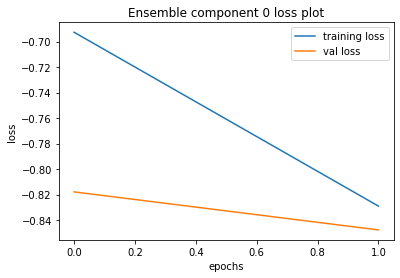

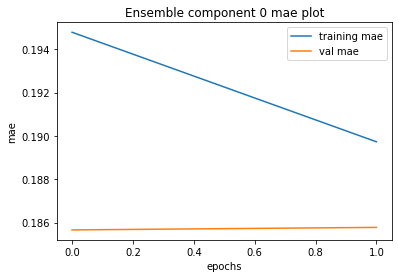

Train on 12750 samples, validate on 4250 samples
Epoch 1/2
12750/12750 - 1s - loss: -5.4179e-01 - mae: 0.2261 - val_loss: -7.6416e-01 - val_mae: 0.1917 - 1s/epoch - 91us/sample
Epoch 2/2
12750/12750 - 1s - loss: -8.0343e-01 - mae: 0.1904 - val_loss: -8.3036e-01 - val_mae: 0.1864 - 943ms/epoch - 74us/sample


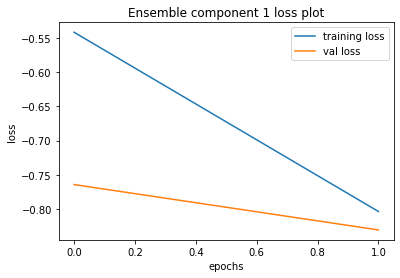

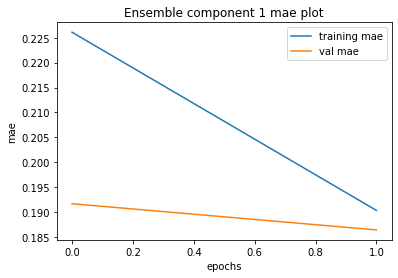

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


mean 
 [[0.4086678 ]
 [0.40178916]
 [0.40277785]
 ...
 [0.39903474]
 [0.40043527]
 [0.4072382 ]]
std 
 [[0.11494827]
 [0.11478642]
 [0.11510794]
 ...
 [0.11596681]
 [0.11485112]
 [0.11463745]]
sample : 
 [[1.17479938]
 [0.46630775]
 [0.51894137]
 ...
 [0.4096666 ]
 [0.13470966]
 [0.52042098]]
mean sample : 
 0.3976031572095636
sample shape : 
 (3000, 1)
prediction mean :
 [[0.40176186]
 [0.39774603]
 [0.39858013]
 ...
 [0.39672443]
 [0.39699453]
 [0.40071657]]
prediction std :
 [[0.33904022]
 [0.33880144]
 [0.3392756 ]
 ...
 [0.340539  ]
 [0.3388969 ]
 [0.33858153]]
prediction samples :
 [[1.17479938]
 [0.46630775]
 [0.51894137]
 ...
 [0.4096666 ]
 [0.13470966]
 [0.52042098]]


In [ ]:
#train_data_adjusted = np.expand_dims(train_data, axis=-1)


#print('Number of estimators in ensemble ', num_estimators)
prediction_mean, prediction_std, prediction_samples, ensemble_model = train_ensemble_model(train_data, train_labels, val_data, val_labels, test_data, epochs=2, num_estimators=2)
print('prediction mean :\n', prediction_mean)
print('prediction std :\n', prediction_std)
print('prediction samples :\n', prediction_samples)
#print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

In [ ]:
def lime_explanation_ensemble(train_input, train_labels, test_input, feature_names, model, pred_fn, flag):
    explainer = LimeTabularExplainer(training_data=train_input, 
                                     mode='regression',
                                     training_labels=train_labels, 
                                     feature_names=feature_names[:-1],
                                     verbose=True,
                                     random_state=0)

    inputs_to_be_explained = test_input.shape[0]
    for i in range(inputs_to_be_explained):
        print('input data : ', test_input[i])
        exp = explainer.explain_instance(data_row=test_input[i], 
                                         predict_fn=pred_fn, 
                                         num_features=8,
                                         id=i)
        print('EXP OBJECT IS ', exp)
        exp.show_in_notebook(show_table=True)
        print('ATTRIBUTE OF THE EXPLANATIONS : ')
        print('class names ', exp.class_names)
        print('domain mapper ', exp.domain_mapper)
        print('dummy label ', exp.dummy_label)
        print('intercept ', exp.intercept)
        print('local exp[0] ', exp.local_exp[0])
        print('local exp[1] ', exp.local_exp[1])
        print('local pred ', exp.local_pred)
        print('max value ', exp.max_value)
        print('min value ', exp.min_value)
        print('mode ', exp.mode)
        print('random state ', exp.random_state)
        print('predicted value ', exp.predicted_value)
        print('score ', exp.score)

        #print('Function values ')
        #print('HTML ')
        #print(exp.as_html(exp.dummy_label, True, True))
        print('explanation out as list ', exp.as_list(label=exp.dummy_label))
        exp.as_pyplot_figure(True)
        plt.savefig('/content/explanation_pyplot_'+str(i)+'.pdf')
        plt.show()
        print(f'PLOT {i} SAVED SUCCESSFULLY')
        #print(e)
        print('explanation as map ', exp.as_map())
        #plt.clf()
        print('COUNTER IS ', i)
        print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

        #exp.available_labels()

    print('This explanation is generated with ', flag, ' as input ')

In [ ]:
# drawing a sample from the distribution that is defined by the pred_mean and pred_std 
# explanation of pred_mean 

#print(test_input.shape)
#print(train_data.shape)

#count = 1

# Analysis of the input 
num_of_samples_to_be_explained = 5
start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_samples_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)


lime_explanation_ensemble(train_data, 
                          train_labels, 
                          test_input, 
                          feature_names, 
                          ensemble_model, 
                          ensemble_model.generate_sample_from_predicted_mean_and_std, 
                          'SAMPLE')

#print('feature_name ', feature_names) 
#print('test input ', test_input)
#print('prediction sample ', ensemble_model.generate_sample_from_predicted_mean_and_std(test_input_adj))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# probably this is how the limits (those besides the name of the features) are provided next to the features: 
print('the quartiles next to the feature importance bar')
for feat in range(len(feature_names[:-1])):
    print(feature_names[feat])
    print(np.array(np.percentile(train_data[:, feat], [25, 50, 75])))

the quartiles next to the feature importance bar
longitude
[0.25423307 0.58366534 0.63247012]
latitude
[0.14680851 0.18085106 0.54893617]
housing_median_age
[0.33333333 0.54901961 0.70588235]
total_rooms
[0.03856597 0.05606959 0.08298405]
total_bedrooms
[0.05375754 0.07917352 0.11830316]
population
[0.02211385 0.03268029 0.04829171]
households
[0.05378832 0.07865818 0.11644496]
median_income
[0.14177046 0.20984883 0.29425111]


In [ ]:
# additional references 
# https://colab.research.google.com/github/GoogleCloudPlatform/ml-on-gcp/blob/master/tutorials/explanations/ai-explanations-tabular.ipynb?hl=ko#scrollTo=BZiM7kywQy6j 
# lime_image.ipynb
# theoretical explanation of how LIME actually works :
# https://cran.r-project.org/web/packages/lime/vignettes/Understanding_lime.html
# https://github.com/marcotcr/lime/issues/113
# https://colab.research.google.com/github/GoogleCloudPlatform/ml-on-gcp/blob/master/tutorials/explanations/ai-explanations-tabular.ipynb?hl=ko#scrollTo=qnMpW5Y9nv2l
#https://www.inovex.de/de/blog/lime-machine-learning-interpretability/
# https://algotech.netlify.app/blog/interpreting-black-box-regression-model-with-lime/#:~:text=There%20exist%20a%20method%20called,model%20locally%20around%20the%20prediction.
# https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

In [ ]:
# video explaining lime (these provide a basic overview, not that useful)
# https://www.youtube.com/watch?v=C80SQe16Rao
# https://www.youtube.com/watch?v=GuAXlV3iBR4

In [ ]:
'''

# TESTBED FOR HISTOGRAM DETAILING
import random 
import matplotlib.pyplot as plt

cont = 1

for i in range(cont):
    
    #exp = self.as_list(label=label, **kwargs)
    fig = plt.figure(figsize=(15, 5))
    #vals = [-0.0015642910097497709, -0.006193702109735619, 0.007176534335879772, 
    #        -0.0075631914531472675, -0.011606796695305309, 0.013962026656112023, 
    #        -0.017696851420039194, -0.0246349957951464]
    vals = [random.randrange(-50, 50, 8) for i in range(8)]
    print(vals)
    names = ['0.33 < housing_median_age <= 0.55', 'total_rooms > 0.08', 'median_income > 0.29', 'population > 0.06', 'longitude <= 0.25', 'households > 0.10', '0.18 < latitude <= 0.55', 'total_bedrooms > 0.10']
    vals.reverse()
    names.reverse()
    print('names ', names)
    colors = ['C1' if x > 0 else 'C0' for x in vals] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    print('colors_set after ', colors_set)
    pos_o = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
    pos = [i + .5 for i in pos_o]
    print('pos values for plot are ', pos)
    print('vals ', vals)
    vals_str = [str(round(val, 3)) for val in vals]
    print('vals_str ', vals_str)

    plt.figure(figsize=(15, 10))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    for i, v in enumerate(vals):
        plt.text(v, i+1, str(v), Bbox = dict(facecolor = 'grey', alpha =.8))
    axx = plt.barh([i for i in pos], vals, align='center', color=colors) # this code appropriate legend
    plt.grid()
    plt.yticks(pos, names)

    labels = colors_set 
    print(labels)     
    print(colors)
    legend_colors = list(set(colors))
    print(set(colors) )
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    print(handles)
    plt.legend(handles, labels)
    plt.show()
 '''

"\n\n# TESTBED FOR HISTOGRAM DETAILING\nimport random \nimport matplotlib.pyplot as plt\n\ncont = 1\n\nfor i in range(cont):\n    \n    #exp = self.as_list(label=label, **kwargs)\n    fig = plt.figure(figsize=(15, 5))\n    #vals = [-0.0015642910097497709, -0.006193702109735619, 0.007176534335879772, \n    #        -0.0075631914531472675, -0.011606796695305309, 0.013962026656112023, \n    #        -0.017696851420039194, -0.0246349957951464]\n    vals = [random.randrange(-50, 50, 8) for i in range(8)]\n    print(vals)\n    names = ['0.33 < housing_median_age <= 0.55', 'total_rooms > 0.08', 'median_income > 0.29', 'population > 0.06', 'longitude <= 0.25', 'households > 0.10', '0.18 < latitude <= 0.55', 'total_bedrooms > 0.10']\n    vals.reverse()\n    names.reverse()\n    print('names ', names)\n    colors = ['C1' if x > 0 else 'C0' for x in vals] # originally negative=red and positive=green (coloring scheme)\n    colors_set = set(colors)\n    print('colors_set before ', colors_set)\n    